# The Min–Max theorem

As described in the 18.303 [class notes](http://math.mit.edu/~stevenj/18.303/fall14/minmax.pdf), the min–max theorem (or "variational theorem") says that, for a self-adjoint operator $\hat{A}$ under some inner product $\langle u, v \rangle$ on some Sobolev space $u,v \in V$ (essentially, $u,v$ such that the "bilinear form" $\langle u, \hat{A} v \rangle$ is finite), the **Rayleigh quotient**
$$
R\{u\} = \frac{\langle u, \hat{A} u \rangle}{\langle u, u \rangle}
$$
evaluated for *any* $u \ne 0$ in $V$ is an upper bound for the minimum eigenvalue of $\hat{A}$ (if any) and a lower bound for the maximum eigenvalue of $\hat{A}$ (if any).  Furthermore, the eigenvalues of $\hat{A}$ are *extrema* of $R\{u\}$.

As described in the notes, this allows us to easily guess the qualitative features of the first few eigenvalues of an operator, even in cases that we can't easily solve analytically.

## Finite-difference discretization

As an example, let's consider $\hat{A} = -\nabla\cdot c\nabla$ for some $c(\vec{x}) > 0$, which is self-adjoint and positive-definite for any finite domain $\Omega$ with Dirichlet boundary conditions $u|_{\partial\Omega}=0$ and the usual inner product $\langle u, v \rangle = \int_\Omega \bar{u} v$.

We'll define the finite-difference discretization by code that is a bit
more general than we have used before: we'll allow the user to pass
in 1d arrays `x` and `y` of the $x$ and $y$ coordinates used in the
discretization (possibly nonuniformly spaced!), *including* the coordinates of the endpoints where $u$ is zero.  We'll also allow the user to pass in an arbitrary *function* $c(x,y)$ that we'll evaluate on the grid as needed.

In [2]:
# compute the first-derivative finite-difference matrix
# for Dirichlet boundaries, given a grid x[:] of x points
# (including the endpoints where the function = 0!).
function sdiff1(x)
    N = length(x) - 2
    dx1 = Float64[1/(x[i+1] - x[i]) for i = 1:N]
    dx2 = Float64[-1/(x[i+1] - x[i]) for i = 2:N+1]
    spdiagm((dx1,dx2), (0,-1), N+1, N)
end

flatten(X) = reshape(X, length(X))

# compute the -∇⋅ c ∇ operator for a function c(x,y)
# and arrays x[:] and y[:] of the x and y points,
# including the endpoints where functions are zero
# (i.e. Dirichlet boundary conditions).
function Laplacian(x, y, c)
    Dx = sdiff1(x)
    Nx = size(Dx,2)
    Dy = sdiff1(y)
    Ny = size(Dy,2)
    
    # discrete Gradient operator:
    G = [kron(speye(Ny), Dx); kron(Dy, speye(Nx))]
    
    # grids for derivatives in x and y directions
    x′ = [0.5*(x[i]+x[i+1]) for i = 1:length(x)-1]
    y′ = [0.5*(y[i]+y[i+1]) for i = 1:length(y)-1]
    
    # evaluate c(x)
    C = spdiagm([ flatten(Float64[c(X,Y) for X in x′, Y in y[2:end-1]]);
                  flatten(Float64[c(X,Y) for X in x[2:end-1], Y in y′]) ])
    
    return G' * C * G # -∇⋅ c ∇
end

Laplacian (generic function with 1 method)

As a quick check to make sure this is working, let's do $\hat{A}=-\nabla^2$ on the box $[0,1]\times[0,1]$, and verify that it gives the expected separable solution and first eigenvalue $2\pi^2$:

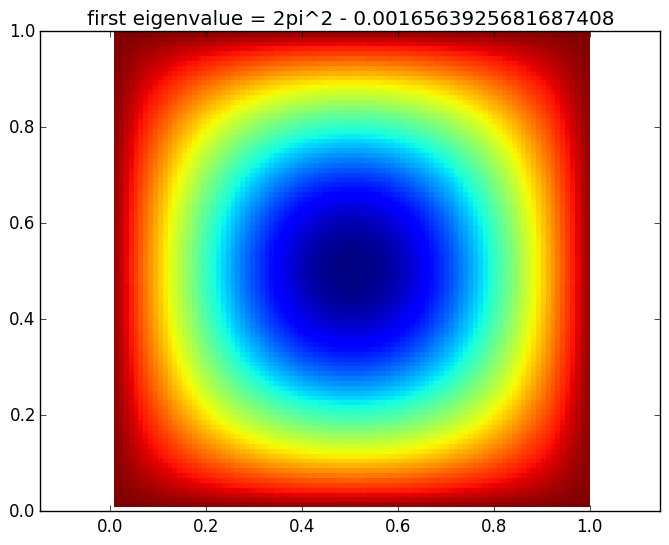

PyObject <matplotlib.text.Text object at 0x31dd762d0>

In [9]:
x = linspace(0,1,100)
A = Laplacian(x, x, (x,y) -> 1.0);
λ, X = eigs(A, nev=1, which=:SM);

using PyPlot
U = reshape(X[:,1],98,98)
pcolor(x[2:end]',x[2:end],U)
axis("equal")
title("first eigenvalue = 2pi^2 - $(2π^2 - λ[1])")

## Min-max Example 1: $-\nabla^2$ in an odd-shaped domain

First, let's consider the usual $-\nabla^2$ operator, but use an oddly shaped domain, using the trick from our previous Kronecker notes of defining a discretization over a box and then taking a subset of rows and columns that are inside our domain.

We'll define an odd spiral-shaped domain as the intersection of the box $[-1,1]\times[-1,1]$ with the region where a [level-set function](https://en.wikipedia.org/wiki/Level_set_method) $\varphi(x,y)$ is $>0$.

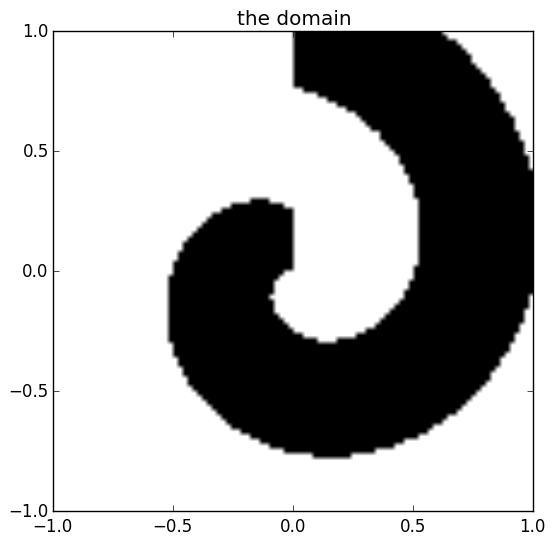

PyObject <matplotlib.text.Text object at 0x321090c90>

In [24]:
N = 100
x = linspace(-1,1,N+2)[2:end-1]
y = x'  # a row vector
r = sqrt(x.^2 .+ y.^2)     # use broadcasting (.+) to make Nx x Ny matrix of radii
θ = broadcast(atan2, y, x) # and angles
φ = exp(-(r - θ*0.5/π - 0.5).^2 / 0.3^2) - 0.5
imshow(φ .> 0, extent=[-1,1,-1,1], cmap="binary")
title("the domain")

Now we'll compute the eigenfunctions.  We'll use the [Interact package](https://github.com/JuliaLang/Interact.jl) to interactively decide which eigenvalue to plot.

Interact.Slider{Int64}([Reactive.Input{Int64}] 10,"which_eig",10,1:20)

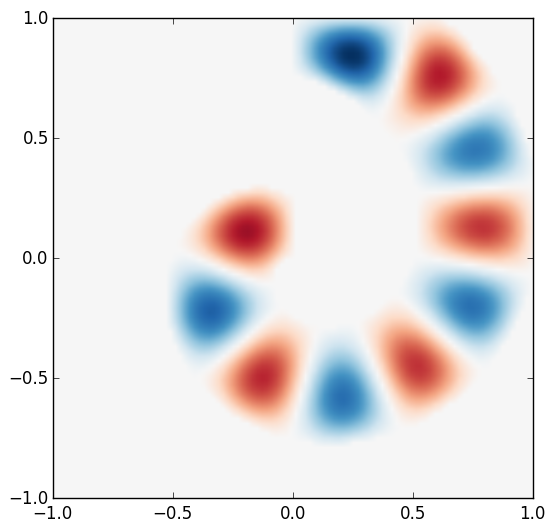

In [26]:
using Interact
x0 = linspace(-1,1,N+2) # includes boundary points, unlike x
Abox = Laplacian(x0, x0, (x,y) -> 1.0);
i = find(φ .> 0)
A = Abox[i,i]
u = zeros(N,N)
λ, X = eigs(A, nev=20, which=:SM);

f = figure()
@manipulate for which_eig in 1:20
    withfig(f) do
        u[i] = X[:,which_eig]
        umax = maxabs(u)
        imshow(u, extent=[-1,1,-1,1], vmin=-umax,vmax=+umax, cmap="RdBu")
    end
end

## Min-max Example 2: $-\nabla \cdot c \nabla$ for non-constant $c$


Now, let's do the box example, but with a non-constant $c$: let $c(x,y) = c_0$ for $x^2 + y^2 < 0.3^2$, and $= 1$ otherwise, and let's see what happens as we vary $c_0$.

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.0,"log10_c0",0.0,-2.0:0.1:2.0)

Interact.Slider{Int64}([Reactive.Input{Int64}] 3,"which_eig",3,1:6)

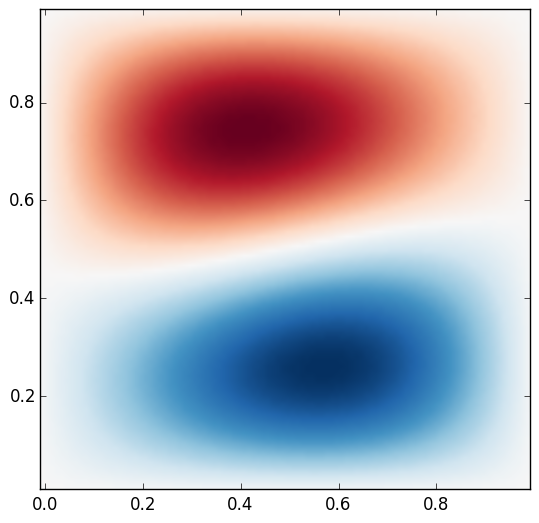

In [13]:
using Interact
f = figure()
N = 100
x = linspace(0,1,N+2)
R = 0.3
@manipulate for log10_c0 in -2:0.1:2, which_eig in 1:6
    withfig(f) do
        c0 = 10.0^log10_c0
        A = Laplacian(x, x, (x,y) -> x^2+y^2 < R^2 ? c0 : 1.0);
        λ, X = eigs(A, nev=which_eig, which=:SM);
        u = reshape(X[:,which_eig], N, N)
        umax = maxabs(u)
        imshow(u, extent=[-x[2],x[end-1],x[2],x[end-1]], vmin=-umax,vmax=+umax, cmap="RdBu")
    end
end

What we see is that the small-λ solutions "want" to be in the region of small $c$.  So, if we
make $c_0$ very small, the solution gets "pulled into" the corner of $c_0$.  Conversely, if we make $c_0$ very large, then the solution is "pushed out of" the corner.

This is consistent with the min-max theorem, which says that the smallest eigenvalues of this operator minimize:
$$
R\{u\} = \frac{\int_\Omega c\Vert\nabla u\Vert^2}{\int_\Omega \Vert u\Vert^2}
$$
which clearly indicates that they want to (a) oscillate as little as possible while (b) concentrating in the regions where $c$ is smallest.